# Capstone project: The Battle of Neighborhoods - Houston vs Dallas

#### *This project is to use venue data collected from Foursquare and compare the two Texas cities, Houston and Dallas respectively. Data will be clustered and analyzed using K-Means algorithm. A more detailed analysis can be found at:
https://github.com/MrChristolpher/Coursera_Capstone/wiki/The-Battle-of-Neighborhoods---Houston-vs-Dallas

### Library imports, Dataframing CSV files

In [211]:
#Imports!
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import geocoder 
import requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium 
from folium import plugins

In [212]:
#create DF's for Houston and Dallas
Houston_data=pd.DataFrame([])
Dallas_data=pd.DataFrame([])
#read csv
#Houston csv file can be found at https://www.kaggle.com/mrchristolpher/houston-texas-neighborhoods-lat-long-list
#Dallas csv file can be found at https://www.kaggle.com/mrchristolpher/dallas-texas-neighborhoods-lat-long
Houston_data = pd.read_csv(r"C:\Users\cdeca\Desktop\DATA SCIENCE\Capstone\Houston_Texas_Neighborhoods_Lat_Long_List - Sheet1.csv")
Dallas_data=pd.read_csv(r"C:\Users\cdeca\Desktop\DATA SCIENCE\Capstone\Dallas_Texas_Neighborhoods_Lat_Long - Sheet1.csv")
Houston_data.head(3)

,Neighborhood,City,State,Latitude,Longitude,Full Address
0,Acres Home,Houston,Texas,29.870719,-95.436543,"Acres Home, Houston, Texas"
1,Addicks,Houston,Texas,29.813269,-95.645476,"Addicks, Houston, Texas"
2,Afton Oaks,Houston,Texas,29.736854,-95.453248,"Afton Oaks, Houston, Texas"


## Cleaning up data, columns and names

In [216]:
#Clean up data for relevant info
Houston_data.drop(['City', 'State', 'Full Address'], axis=1, inplace = True)

In [224]:
print(Houston_data.shape)
Houston_data.head(5)

(88, 3)


,Neighborhood,Latitude,Longitude
0,Acres Home,29.870719,-95.436543
1,Addicks,29.813269,-95.645476
2,Afton Oaks,29.736854,-95.453248
3,Alief,29.682720,-95.593239
4,Astrodome Area,29.685208,-95.403226


In [214]:
Dallas_data.head(5)

,Neighborhoods,City,State,Latitude,Longitude,Full Address
0,Bachman-Northwest Highway,Dallas,Texas,32.862723,-96.857822,"Bachman-Northwest Highway, Dallas, Texas"
1,Bent Tree North,Dallas,Texas,32.998795,-96.822027,"Bent Tree North, Dallas, Texas"
2,Bent Tree West,Dallas,Texas,32.994855,-96.837975,"Bent Tree West, Dallas, Texas"
3,Bertrand,Dallas,Texas,32.763743,-96.747771,"Bertrand, Dallas, Texas"
4,Beverly Hills,Dallas,Texas,32.864207,-96.804427,"Beverly Hills, Dallas, Texas"


In [219]:
Dallas_data.drop(['City', 'State', 'Full Address'], axis=1, inplace = True)

In [220]:
Dallas_data.rename(columns={'Neighborhoods':'Neighborhood'}, inplace=True)

In [223]:
print(Dallas_data.shape)
Dallas_data.head(5)

(118, 3)


,Neighborhood,Latitude,Longitude
0,Bachman-Northwest Highway,32.862723,-96.857822
1,Bent Tree North,32.998795,-96.822027
2,Bent Tree West,32.994855,-96.837975
3,Bertrand,32.763743,-96.747771
4,Beverly Hills,32.864207,-96.804427


## Foursquare Data and Credentials

In [225]:
CLIENT_ID = '4SG2VPTY03V324ZRC5G2T2FK44IHNF3INDYXQX0CD4C2A1U5' # your Foursquare ID
CLIENT_SECRET = 'DUN5C1GOSEPDYYJ5NFMI34U0CFVRZ1CDWVYMEVE0PNGYB1K0' # your Foursquare Secret
VERSION = '20201200' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [226]:
#Houston Coordinates : https://latitudelongitude.org/us/houston/
h_lat = 29.76328
h_long = -95.36327

#Dallas Coordinates : https://latitudelongitude.org/us/dallas/
d_lat = 32.78306
d_long = -96.80667

In [29]:
#function to repeat the same process to all the postal codes in Houston, Texas
#houston is twice the size of dallas, without getting too granular into finding exact sizing of each neighborhood (lack of data) and averaging
#I made the decision to just twice the size of the houston radius compared to that of dallas'

def h_getNearbyVenues(names, latitudes, longitudes, radius=1600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
#function to repeat the same process to all the postal codes in Dallas, Texas
#houston is twice the size of dallas, without getting too granular into finding exact sizing of each neighborhood (lack of data) and averaging
#I made the decision to just half the size of the dallas radius compared to that of houston's

def d_getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
print("Getting venues inside the following Neighborhoods of Houston:")
Houston_venues = h_getNearbyVenues(names=Houston_data['Neighborhood'],
                                   latitudes=Houston_data['Latitude'],
                                   longitudes=Houston_data['Longitude']
                                  )
print(" ")
print("Getting venues inside the following Neighborhoods of Dallas:")
Dallas_Venues = d_getNearbyVenues(names=Dallas_data['Neighborhood'],
                                   latitudes=Dallas_data['Latitude'],
                                   longitudes=Dallas_data['Longitude']
                                  )

Getting venues inside the following Neighborhoods of Houston:
Acres Home
Addicks
Afton Oaks
Alief
Astrodome Area
Braeburn
Braeswood
Brays Oaks 
Briar Forest
Carverdale
Central Northwest 
Central Southwest
Clear Lake
Clinton Park
Denver Harbor
Downtown
East Houston
East Little York
Edgebrook
El Dorado
Eldridge
Fairbanks 
Fondren Gardens
Fort Bend
Fourth Ward
Golfcrest
Greater Eastwood
Greater Fifth Ward
Greater Greenspoint
Greater Heights
Greater Hobby Area
Greater Inwood
Greater OST
Greater Third Ward
Greater Uptown
Greenway
Gulfgate Riverview
Gulfton
Harrisburg
Hidden Valley
Hunterwood
IAH Airport
Independence Heights
Jensen
Kashmere Gardens
Kingwood
Lake Houston
Langwood
Lawndale
Lazybrook
MacGregor
Magnolia Park
Meadowbrook
Medical Center
Memorial
Meyerland
Mid-West 
Midtown
Minnetex
Museum Park
Neartown
Northshore
Northside
Northside Village
Park Place
Pecan Park
Pleasantville Area
Second Ward
Settegast
Sharpstown
South Acres
South Belt
South Main
South Park
Spring Branch Central
S

In [149]:
print(Houston_venues.shape)
print('There are {} uniques venue categories in Houston.'.format(len(Houston_venues['Venue Category'].unique())))

(4153, 7)
There are 318 uniques venue categories in Houston.


In [150]:
print(Dallas_Venues.shape)
print('There are {} uniques venue categories in Dallas.'.format(len(Dallas_Venues['Venue Category'].unique())))

(3020, 7)
There are 264 uniques venue categories in Dallas.


### Getting list for top 5 venue count for both Houston and Dallas

In [71]:
#top 5 neighborhoods by venue count Houston
h_grouped = Houston_venues.groupby('Neighborhood').count().reset_index()
h_grouped.sort_values('Venue', ascending=False)
top_h = h_grouped[h_grouped['Venue']==100]
top_5_h=top_h.head(5)
top_5_h

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Afton Oaks,100,100,100,100,100,100
15,Downtown,100,100,100,100,100,100
24,Fourth Ward,100,100,100,100,100,100
29,Greater Heights,100,100,100,100,100,100
34,Greater Uptown,100,100,100,100,100,100


In [64]:
#top 5 neighborhoods by venue count Dallas
d_grouped = Dallas_Venues.groupby('Neighborhood').count().reset_index()
d_grouped.sort_values('Venue', ascending=False)
top_d = d_grouped[d_grouped['Venue']>=50]
top_5_d=top_d.sort_values('Venue',ascending=False).head(5)
top_5_d

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
50,Kimball,100,100,100,100,100,100
24,Downtown Dallas,100,100,100,100,100,100
94,RUFCO,100,100,100,100,100,100
93,RANDCO,100,100,100,100,100,100
22,Deep Ellum,93,93,93,93,93,93


## Data Visualization and Exploration 

In [73]:
## Picking major neighborhoods from top 5 list above
h_neighborhoods = ['Afton Oaks', 'Downtown', 'Fourth Ward', 'Greater Heights', 'Greater Uptown']
d_neighborhoods = ['Kimball', 'Downtown Dallas', 'RUFCO', 'RANDCO', 'Deep Ellum']

def nearbyvenues_count(venues_df, neighborhood):
    venues_count = venues_df
    venues_count = venues_count.rename(columns={'Venue Category': 'Category'})
    venues_count = venues_count.groupby(['Neighborhood']).Category.value_counts().to_frame("Counts")
    fig, ax = plt.subplots(1,1,figsize=(20, 7)) 
    fig.subplots_adjust(left=0.115, right=0.88)
    venues_plot =  venues_count['Counts'].loc[neighborhood][:10].head(10) 
    pos = np.arange(len(venues_plot))
    ax.set_title(neighborhood,size=20)
    freqchart = ax.barh(pos, venues_plot,align='center',height=0.5,tick_label=venues_plot.index)
    
    return freqchart

<BarContainer object of 10 artists>

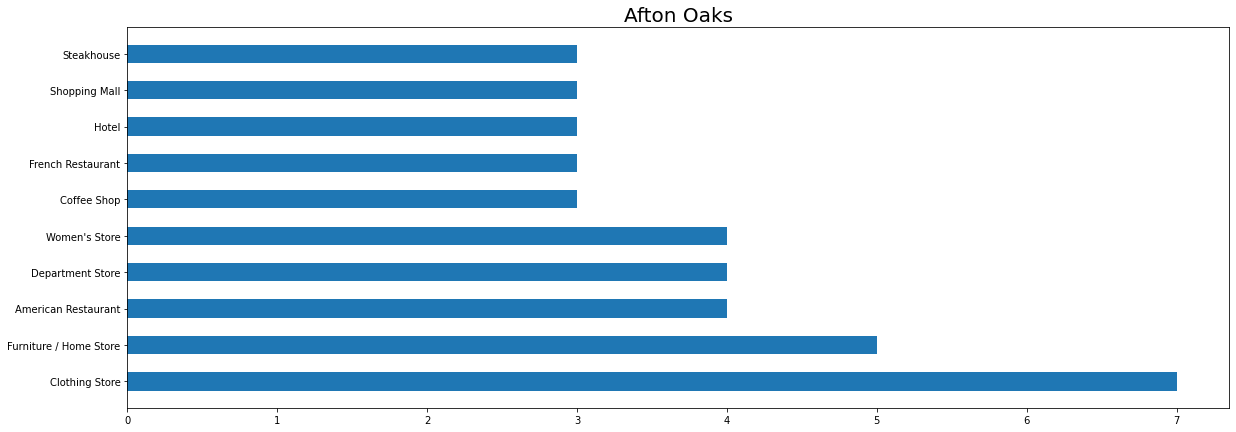

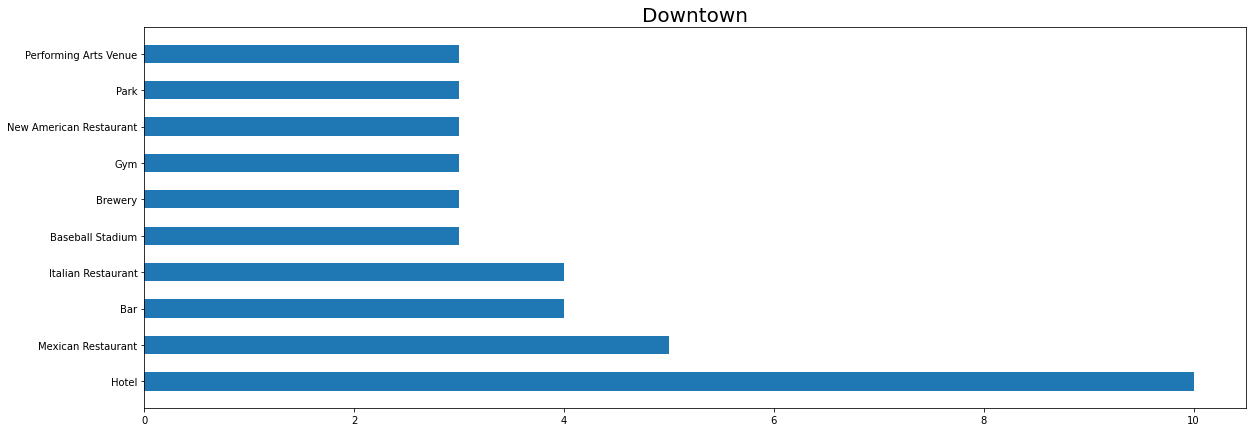

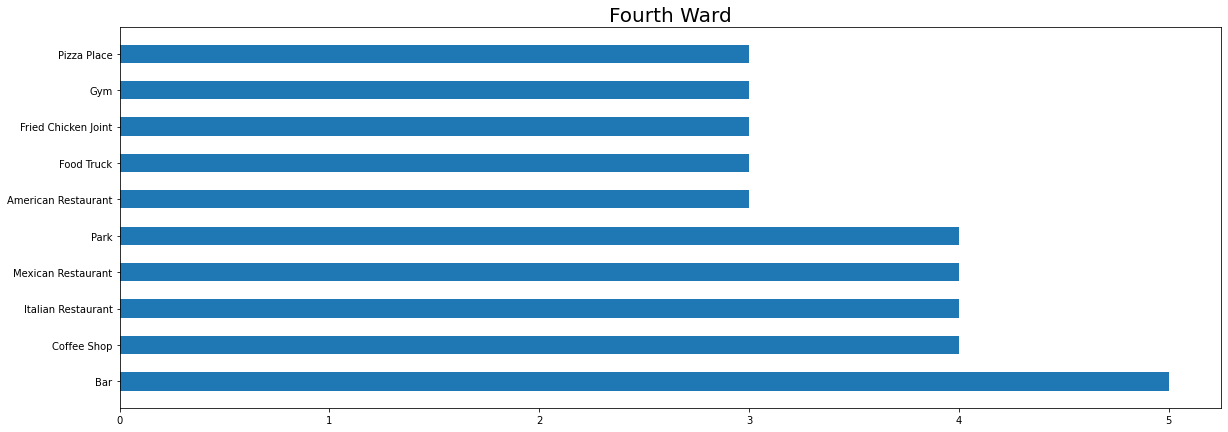

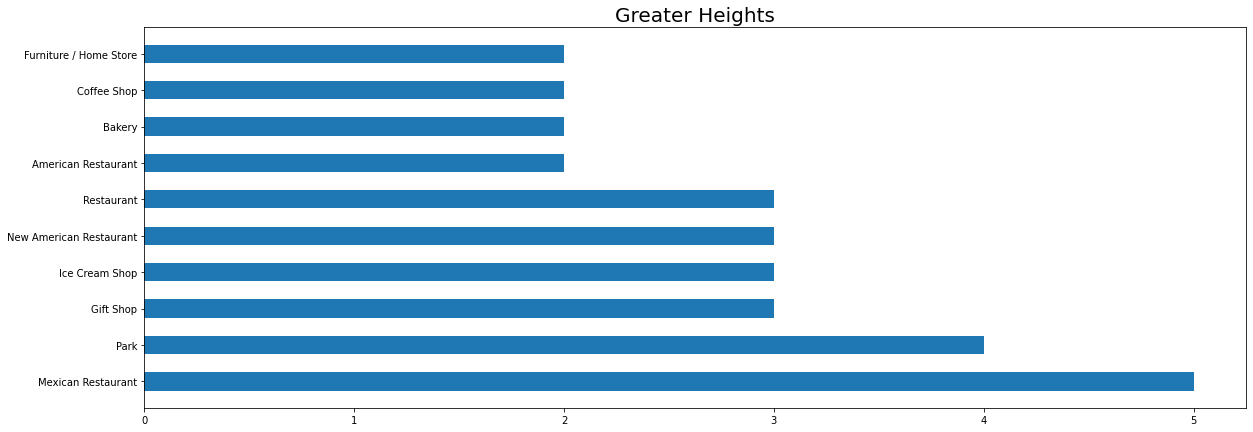

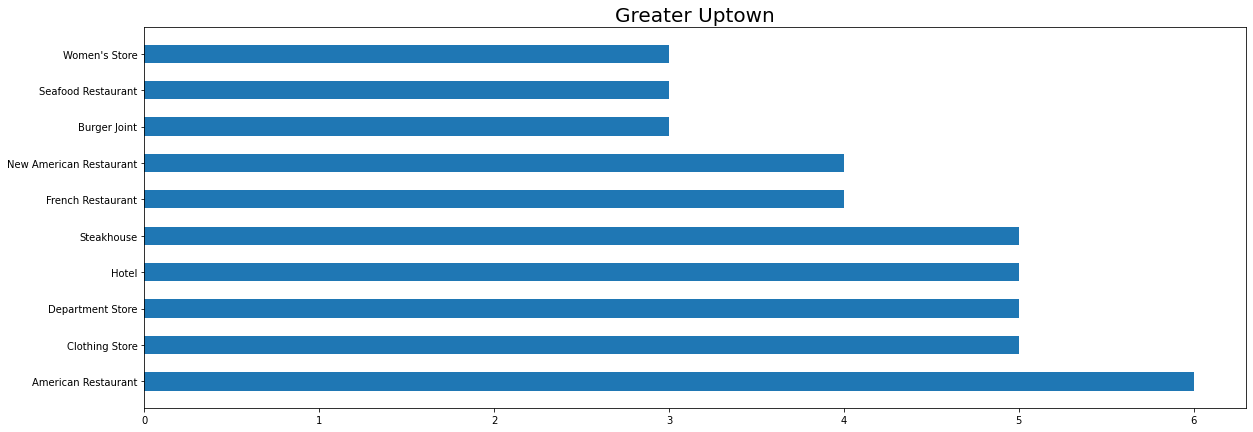

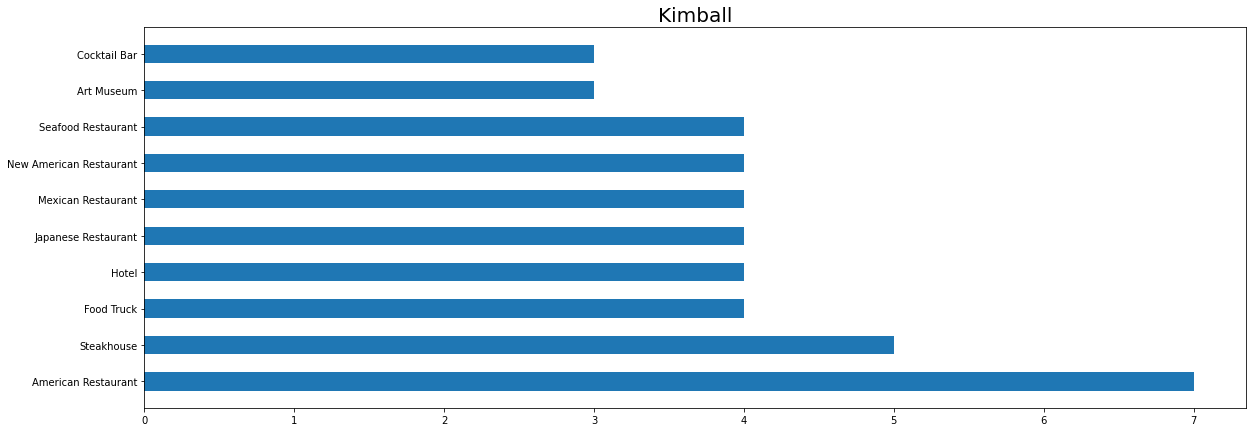

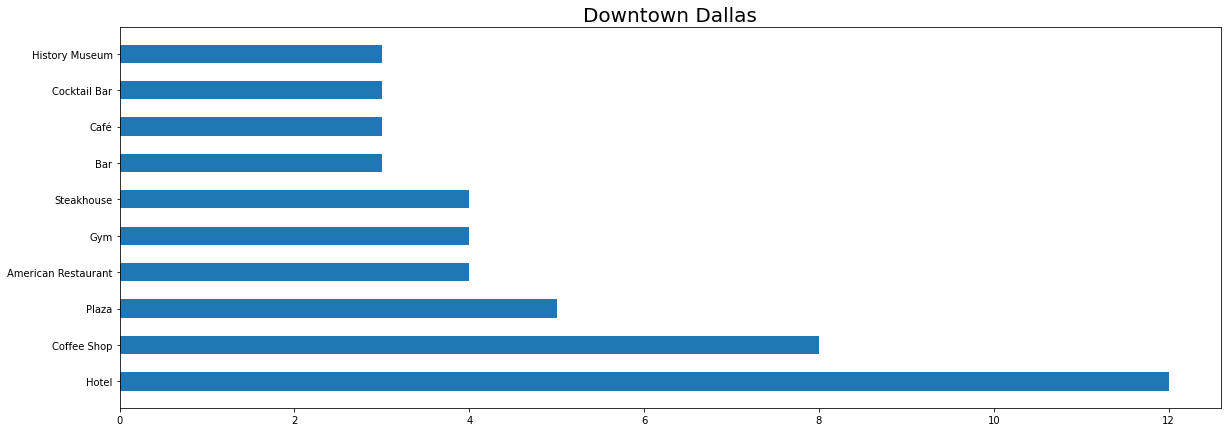

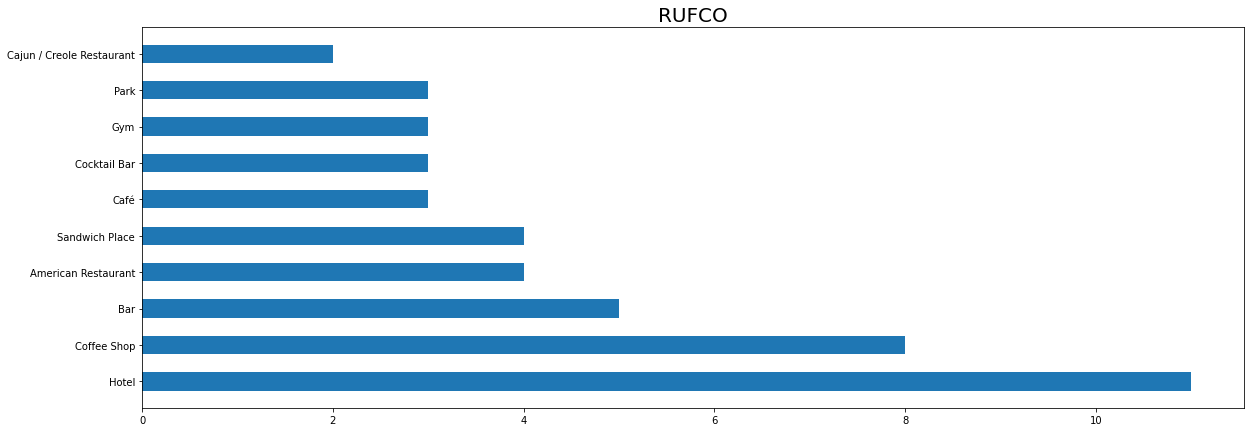

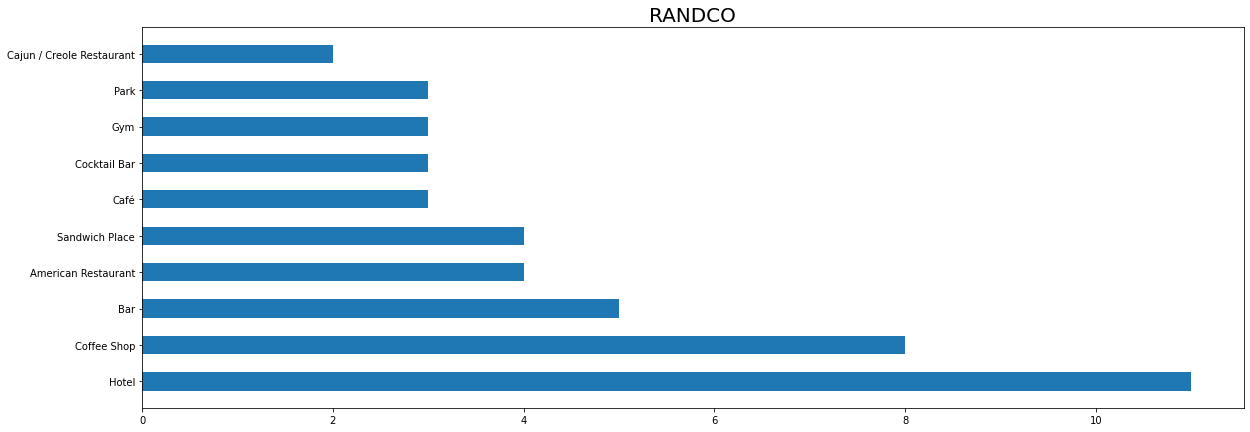

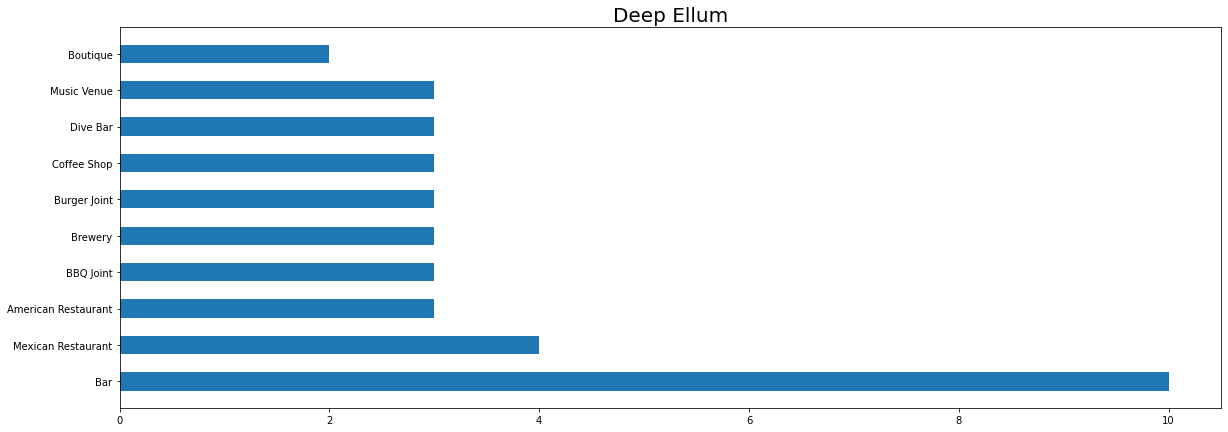

In [76]:
## Frequency bar chart for neighborhoods from either city
nearbyvenues_count(Houston_venues, h_neighborhoods[0])
nearbyvenues_count(Houston_venues, h_neighborhoods[1])
nearbyvenues_count(Houston_venues, h_neighborhoods[2])
nearbyvenues_count(Houston_venues, h_neighborhoods[3])
nearbyvenues_count(Houston_venues, h_neighborhoods[4])
nearbyvenues_count(Dallas_Venues, d_neighborhoods[0])
nearbyvenues_count(Dallas_Venues, d_neighborhoods[1])
nearbyvenues_count(Dallas_Venues, d_neighborhoods[2])
nearbyvenues_count(Dallas_Venues, d_neighborhoods[3])
nearbyvenues_count(Dallas_Venues, d_neighborhoods[4])

### Categorize venues into dataframes, onehot encoding

#### Onehot and group

In [78]:
# one hot encoding
houston_onehot = pd.get_dummies(Houston_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
houston_onehot['Neighborhood'] = Houston_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [houston_onehot.columns[-1]] + list(houston_onehot.columns[:-1])
houston_onehot = houston_onehot[fixed_columns]

houston_onehot.head()

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Football Field,College Rec Center,College Residence Hall,College Theater,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Exhibit,Eye Doctor,Fabric Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marine Terminal,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piano Bar,Picnic Area,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Spo

In [79]:
houston_grouped = houston_onehot.groupby('Neighborhood').mean().reset_index()

In [80]:
# one hot encoding
dallas_onehot = pd.get_dummies(Dallas_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dallas_onehot['Neighborhood'] = Dallas_Venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dallas_onehot.columns[-1]] + list(dallas_onehot.columns[:-1])
dallas_onehot = dallas_onehot[fixed_columns]

dallas_onehot.head()

,Neighborhood,ATM,Accessories Store,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Quad,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Food,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bachman-Northwest Highway,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [81]:
dallas_grouped = dallas_onehot.groupby('Neighborhood').mean().reset_index()

In [82]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [83]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe for Houston
Houston_venues_sorted = pd.DataFrame(columns=columns)
Houston_venues_sorted['Neighborhood'] = houston_grouped['Neighborhood']

for ind in np.arange(houston_grouped.shape[0]):
    Houston_venues_sorted.iloc[ind, 1:] = return_most_common_venues(houston_grouped.iloc[ind, :], num_top_venues)

Houston_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acres Home,Chinese Restaurant,Construction & Landscaping,Business Service,Bus Station,Discount Store,Farmers Market,Empanada Restaurant,Event Service,Exhibit,Eye Doctor
1,Addicks,Outdoors & Recreation,BBQ Joint,Government Building,Park,Dog Run,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Exhibit
2,Afton Oaks,Clothing Store,Furniture / Home Store,Women's Store,Department Store,American Restaurant,French Restaurant,Steakhouse,Shopping Mall,Hotel,Coffee Shop
3,Alief,Fast Food Restaurant,Pizza Place,Donut Shop,Grocery Store,Video Store,Discount Store,Furniture / Home Store,Spa,Gas Station,Café
4,Astrodome Area,Mobile Phone Shop,Sandwich Place,Pizza Place,Grocery Store,Mexican Restaurant,BBQ Joint,Mediterranean Restaurant,Bakery,Burger Joint,Restaurant
5,Braeburn,Cosmetics Shop,Discount Store,Chinese Restaurant,Bank,Sandwich Place,Clothing Store,Gas Station,Rental Car Location,Bar,Pharmacy
6,Braeswood,Gym,Park,Fried Chicken Joint,Burger Joint,Bakery,Playground,Liquor Store,Gas Station,Furniture / Home Store,Beer Store
7,Brays Oaks,Pizza Place,Fast Food Restaurant,Grocery Store,Discount Store,Video Store,Fried Chicken Joint,Park,Dry Cleaner,Bank,Sandwich Place
8,Briar Forest,Sandwich Place,Grocery Store,Mexican Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Pizza Place,Bank,Thai Restaurant,Asian Restaurant
9,Carverdale,Hotel,Gas Station,BBQ Joint,Burger Joint,Auto Garage,Breakfast Spot,Business Service,Taco Place,Go Kart Track,Sandwich Place


In [84]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe for Dallas
Dallas_venues_sorted = pd.DataFrame(columns=columns)
Dallas_venues_sorted['Neighborhood'] = dallas_grouped['Neighborhood']

for ind in np.arange(dallas_grouped.shape[0]):
    Dallas_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dallas_grouped.iloc[ind, :], num_top_venues)

Dallas_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bachman-Northwest Highway,Mexican Restaurant,Fast Food Restaurant,Convenience Store,Coffee Shop,Gym,Shoe Store,Beer Bar,Furniture / Home Store,Big Box Store,Frozen Yogurt Shop
1,Bent Tree North,American Restaurant,Chinese Restaurant,Pizza Place,Nail Salon,Fast Food Restaurant,Flower Shop,Thai Restaurant,Burger Joint,Grocery Store,Supplement Shop
2,Bent Tree West,Convenience Store,Salon / Barbershop,Thai Restaurant,Sushi Restaurant,Pizza Place,Gym / Fitness Center,Donut Shop,Sandwich Place,Spa,Food Truck
3,Bertrand,Fried Chicken Joint,Discount Store,Burger Joint,Fast Food Restaurant,Light Rail Station,Thrift / Vintage Store,Deli / Bodega,Escape Room,Football Stadium,Food Truck
4,Beverly Hills,American Restaurant,Bakery,Shoe Store,Juice Bar,Seafood Restaurant,Cupcake Shop,Department Store,Sandwich Place,Coffee Shop,Shopping Mall
5,Botello,Zoo Exhibit,Mexican Restaurant,Fast Food Restaurant,Bus Station,Historic Site,Light Rail Station,Gas Station,Home Service,Fried Chicken Joint,Taco Place
6,Briarwood,Convenience Store,Restaurant,Construction & Landscaping,Dive Bar,American Restaurant,Dance Studio,Mexican Restaurant,Escape Room,Event Space,Fabric Shop
7,Brookhollow,Mexican Restaurant,Recreation Center,Automotive Shop,Golf Course,Gym / Fitness Center,Café,Video Store,Pet Store,Convenience Store,Flower Shop
8,Bryan Place,Beach Bar,Performing Arts Venue,Park,Coffee Shop,Fast Food Restaurant,Café,Furniture / Home Store,Boutique,Snack Place,Burger Joint
9,Buckner Terrace,Convenience Store,Fried Chicken Joint,Breakfast Spot,Fast Food Restaurant,Pizza Place,Discount Store,Motel,Café,Mexican Restaurant,Seafood Restaurant


## K-Means, Cluster Analysis - using the euclidean metric

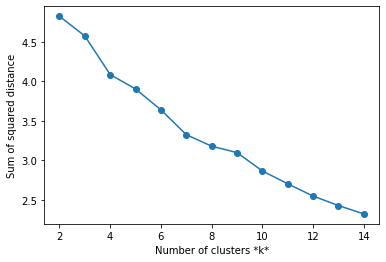

In [85]:
houston_grouped_clustering = houston_grouped.drop('Neighborhood', 1)

## Finding the optimal K using elbow method
from sklearn.metrics import silhouette_score

sse = []
sscr =[]
list_k = list(range(2, 15))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0).fit(houston_grouped_clustering)
    sse.append(km.inertia_)
    sscr.append(silhouette_score(houston_grouped_clustering, km.labels_, metric='euclidean'))

plt.figure(figsize=(6, 4))
plt.plot(list_k, sse, '-o',label='sse')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

## Houston shows an elbow at k=4

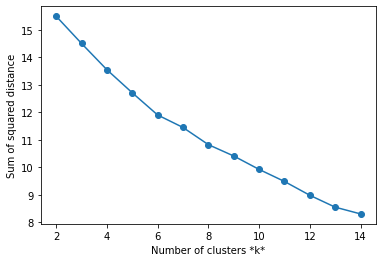

In [86]:
dallas_grouped_clustering = dallas_grouped.drop('Neighborhood', 1)

## Finding the optimal K using elbow method
from sklearn.metrics import silhouette_score

sse = []
sscr =[]
list_k = list(range(2, 15))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0).fit(dallas_grouped_clustering)
    sse.append(km.inertia_)
    sscr.append(silhouette_score(dallas_grouped_clustering, km.labels_, metric='euclidean'))

plt.figure(figsize=(6, 4))
plt.plot(list_k, sse, '-o',label='sse')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

## Dallas shows an elbow at k=6

# Houston

In [97]:
# set number of clusters
kclusters = 4

houston_grouped_clustering = houston_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(houston_grouped_clustering)

Houston_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([2, 1, 1, 0, 1, 1, 1, 0, 1, 1])

In [98]:
houston_merged = Houston_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
houston_merged = houston_merged.join(Houston_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

houston_merged.head() 

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acres Home,29.870719,-95.436543,2,Chinese Restaurant,Construction & Landscaping,Business Service,Bus Station,Discount Store,Farmers Market,Empanada Restaurant,Event Service,Exhibit,Eye Doctor
1,Addicks,29.813269,-95.645476,1,Outdoors & Recreation,BBQ Joint,Government Building,Park,Dog Run,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Exhibit
2,Afton Oaks,29.736854,-95.453248,1,Clothing Store,Furniture / Home Store,Women's Store,Department Store,American Restaurant,French Restaurant,Steakhouse,Shopping Mall,Hotel,Coffee Shop
3,Alief,29.682720,-95.593239,0,Fast Food Restaurant,Pizza Place,Donut Shop,Grocery Store,Video Store,Discount Store,Furniture / Home Store,Spa,Gas Station,Café
4,Astrodome Area,29.685208,-95.403226,1,Mobile Phone Shop,Sandwich Place,Pizza Place,Grocery Store,Mexican Restaurant,BBQ Joint,Mediterranean Restaurant,Bakery,Burger Joint,Restaurant


## Houston Map

In [169]:
# create map
houston_map_clusters = folium.Map(location=[h_lat, h_long], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(houston_merged['Latitude'], houston_merged['Longitude'], houston_merged['Neighborhood'], houston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(houston_map_clusters)
       
houston_map_clusters

## Group 1 - 22 Neighborhoods

In [134]:
print(houston_merged.loc[houston_merged['Cluster Labels'] == 0, houston_merged.columns[[0] + list(range(4, houston_merged.shape[1]))]].shape)
houston_merged.loc[houston_merged['Cluster Labels'] == 0, houston_merged.columns[[0] + list(range(4, houston_merged.shape[1]))]]

(22, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Alief,Fast Food Restaurant,Pizza Place,Donut Shop,Grocery Store,Video Store,Discount Store,Furniture / Home Store,Spa,Gas Station,Café
7,Brays Oaks,Pizza Place,Fast Food Restaurant,Grocery Store,Discount Store,Video Store,Fried Chicken Joint,Park,Dry Cleaner,Bank,Sandwich Place
13,Clinton Park,Donut Shop,Intersection,Tourist Information Center,Restaurant,Gas Station,Fast Food Restaurant,Port,Boat or Ferry,Eye Doctor,Electronics Store
14,Denver Harbor,Sandwich Place,Fast Food Restaurant,Mexican Restaurant,Gas Station,Pizza Place,Pharmacy,Discount Store,Fried Chicken Joint,Bank,Diner
22,Fondren Gardens,Fast Food Restaurant,Gas Station,Park,Clothing Store,Mobile Phone Shop,Fried Chicken Joint,Sandwich Place,Intersection,Bakery,Bar
25,Golfcrest,Fast Food Restaurant,Pizza Place,Video Store,Pharmacy,Shoe Store,Park,Sandwich Place,Clothing Store,Donut Shop,Fried Chicken Joint
27,Greater Fifth Ward,Park,Intersection,Sandwich Place,Pharmacy,Fast Food Restaurant,Discount Store,Pub,Gas Station,Music Venue,Market
30,Greater Hobby Area,Food Truck,Bakery,Sandwich Place,Ice Cream Shop,Mexican Restaurant,Burger Joint,Video Store,Fast Food Restaurant,Discount Store,Gas Station
31,Greater Inwood,Fast Food Restaurant,Pharmacy,Pizza Place,Discount Store,Grocery Store,Paper / Office Supplies Store,Bank,Chinese Restaurant,Sandwich Place,Tennis Court
32,Greater OST,Fried Chicken Joint,Fast Food Restaurant,Pharmacy,Discount Store,Chinese Restaurant,Gas Station,Market,Cosmetics Shop,Donut Shop,Shipping Store


## Group 2 - 56 Neighborhoods

In [135]:
print(houston_merged.loc[houston_merged['Cluster Labels'] == 1, houston_merged.columns[[0] + list(range(4, houston_merged.shape[1]))]].shape)
houston_merged.loc[houston_merged['Cluster Labels'] == 1, houston_merged.columns[[0] + list(range(4, houston_merged.shape[1]))]]

(56, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Addicks,Outdoors & Recreation,BBQ Joint,Government Building,Park,Dog Run,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Exhibit
2,Afton Oaks,Clothing Store,Furniture / Home Store,Women's Store,Department Store,American Restaurant,French Restaurant,Steakhouse,Shopping Mall,Hotel,Coffee Shop
4,Astrodome Area,Mobile Phone Shop,Sandwich Place,Pizza Place,Grocery Store,Mexican Restaurant,BBQ Joint,Mediterranean Restaurant,Bakery,Burger Joint,Restaurant
5,Braeburn,Cosmetics Shop,Discount Store,Chinese Restaurant,Bank,Sandwich Place,Clothing Store,Gas Station,Rental Car Location,Bar,Pharmacy
6,Braeswood,Gym,Park,Fried Chicken Joint,Burger Joint,Bakery,Playground,Liquor Store,Gas Station,Furniture / Home Store,Beer Store
8,Briar Forest,Sandwich Place,Grocery Store,Mexican Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Pizza Place,Bank,Thai Restaurant,Asian Restaurant
9,Carverdale,Hotel,Gas Station,BBQ Joint,Burger Joint,Auto Garage,Breakfast Spot,Business Service,Taco Place,Go Kart Track,Sandwich Place
10,Central Northwest,Park,Pizza Place,Discount Store,Spa,Trail,Gas Station,Bank,Burger Joint,Mexican Restaurant,Salon / Barbershop
12,Clear Lake,Pizza Place,Intersection,Salon / Barbershop,Supermarket,Park,Coffee Shop,Italian Restaurant,Donut Shop,Liquor Store,Sandwich Place
15,Downtown,Hotel,Mexican Restaurant,Italian Restaurant,Bar,Pizza Place,Taco Place,Baseball Stadium,Brewery,Vietnamese Restaurant,Performing Arts Venue


## Group 3 - 9 Neighborhoods

In [146]:
print(houston_merged.loc[houston_merged['Cluster Labels'] == 2, houston_merged.columns[[0] + list(range(4, houston_merged.shape[1]))]].shape)
houston_merged.loc[houston_merged['Cluster Labels'] == 2, houston_merged.columns[[0] + list(range(4, houston_merged.shape[1]))]]

(9, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acres Home,Chinese Restaurant,Construction & Landscaping,Business Service,Bus Station,Discount Store,Farmers Market,Empanada Restaurant,Event Service,Exhibit,Eye Doctor
11,Central Southwest,Home Service,Gas Station,Convenience Store,Park,Basketball Court,Discount Store,Fast Food Restaurant,Event Service,Exhibit,Eye Doctor
16,East Houston,Discount Store,Seafood Restaurant,Donut Shop,Food,Convenience Store,Moving Target,Fried Chicken Joint,Museum,Burger Joint,BBQ Joint
17,East Little York,Discount Store,Gas Station,Convenience Store,Food,Brewery,Grocery Store,Clothing Store,Fast Food Restaurant,Event Service,Exhibit
19,El Dorado,Construction & Landscaping,Home Service,Ice Cream Shop,Rental Car Location,Zoo,Fast Food Restaurant,Electronics Store,Empanada Restaurant,Event Service,Exhibit
58,Minnetex,Paintball Field,Construction & Landscaping,Home Service,Clothing Store,Discount Store,Farmers Market,Electronics Store,Empanada Restaurant,Event Service,Exhibit
68,Settegast,Other Repair Shop,Concert Hall,American Restaurant,Discount Store,Fast Food Restaurant,Empanada Restaurant,Event Service,Exhibit,Eye Doctor,Fabric Shop
70,South Acres,Seafood Restaurant,Construction & Landscaping,Mobile Phone Shop,Cocktail Bar,Discount Store,Farmers Market,Electronics Store,Empanada Restaurant,Event Service,Exhibit
79,Trinity,Discount Store,Burger Joint,Bakery,Park,Gas Station,American Restaurant,Outdoor Sculpture,BBQ Joint,Construction & Landscaping,Food


## Group 4 - 1 Neighborhood

In [147]:
print(houston_merged.loc[houston_merged['Cluster Labels'] == 3, houston_merged.columns[[0] + list(range(4, houston_merged.shape[1]))]].shape)
houston_merged.loc[houston_merged['Cluster Labels'] == 3, houston_merged.columns[[0] + list(range(4, houston_merged.shape[1]))]]

(1, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Lake Houston,Business Service,Zoo,Fast Food Restaurant,Empanada Restaurant,Event Service,Exhibit,Eye Doctor,Fabric Shop,Farmers Market,Filipino Restaurant


# Dallas

In [185]:
# set number of clusters
kclusters = 6

dallas_grouped_clustering = dallas_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dallas_grouped_clustering)

Dallas_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 1, 2, 2, 2, 2, 2, 2])

In [186]:
dallas_merged = Dallas_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
dallas_merged = dallas_merged.join(Dallas_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dallas_merged.head() 

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bachman-Northwest Highway,32.862723,-96.857822,2,Mexican Restaurant,Fast Food Restaurant,Convenience Store,Coffee Shop,Gym,Shoe Store,Beer Bar,Furniture / Home Store,Big Box Store,Frozen Yogurt Shop
1,Bent Tree North,32.998795,-96.822027,2,American Restaurant,Chinese Restaurant,Pizza Place,Nail Salon,Fast Food Restaurant,Flower Shop,Thai Restaurant,Burger Joint,Grocery Store,Supplement Shop
2,Bent Tree West,32.994855,-96.837975,2,Convenience Store,Salon / Barbershop,Thai Restaurant,Sushi Restaurant,Pizza Place,Gym / Fitness Center,Donut Shop,Sandwich Place,Spa,Food Truck
3,Bertrand,32.763743,-96.747771,1,Fried Chicken Joint,Discount Store,Burger Joint,Fast Food Restaurant,Light Rail Station,Thrift / Vintage Store,Deli / Bodega,Escape Room,Football Stadium,Food Truck
4,Beverly Hills,32.864207,-96.804427,2,American Restaurant,Bakery,Shoe Store,Juice Bar,Seafood Restaurant,Cupcake Shop,Department Store,Sandwich Place,Coffee Shop,Shopping Mall


## Dallas Map

In [195]:
# create map
dallas_map_clusters = folium.Map(location=[d_lat, d_long], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dallas_merged['Latitude'], dallas_merged['Longitude'], dallas_merged['Neighborhood'], dallas_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.75).add_to(dallas_map_clusters)
       
dallas_map_clusters

## Group 1 - 1 Neighborhood

In [128]:
print(dallas_merged.loc[dallas_merged['Cluster Labels'] == 0, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]].shape)
dallas_merged.loc[dallas_merged['Cluster Labels'] == 0, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]]

(1, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,Riverway Estates-Bruton Terrace,Donut Shop,Zoo Exhibit,Football Stadium,Food Truck,Food Court,Food,Flower Shop,Flea Market,Financial or Legal Service,Fast Food Restaurant


## Group 2 - 4 Neighborhoods

In [129]:
print(dallas_merged.loc[dallas_merged['Cluster Labels'] == 1, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]].shape)
dallas_merged.loc[dallas_merged['Cluster Labels'] == 1, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]]

(4, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bertrand,Fried Chicken Joint,Discount Store,Burger Joint,Fast Food Restaurant,Light Rail Station,Thrift / Vintage Store,Deli / Bodega,Escape Room,Football Stadium,Food Truck
25,Eastwood Estates,Discount Store,Convenience Store,Motorcycle Shop,Construction & Landscaping,Grocery Store,Nail Salon,Burger Joint,Rental Car Location,Chinese Restaurant,Fast Food Restaurant
34,Fredrick Douglas,Fried Chicken Joint,Automotive Shop,Discount Store,Video Store,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant
102,South East Dallas,Discount Store,Zoo Exhibit,Fast Food Restaurant,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Financial or Legal Service,Donut Shop


## Group 3 - 108 Neighborhoods

In [148]:
print(dallas_merged.loc[dallas_merged['Cluster Labels'] == 2, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]].shape)
dallas_merged.loc[dallas_merged['Cluster Labels'] == 2, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]]

(108, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bachman-Northwest Highway,Mexican Restaurant,Fast Food Restaurant,Convenience Store,Coffee Shop,Gym,Shoe Store,Beer Bar,Furniture / Home Store,Big Box Store,Frozen Yogurt Shop
1,Bent Tree North,American Restaurant,Chinese Restaurant,Pizza Place,Nail Salon,Fast Food Restaurant,Flower Shop,Thai Restaurant,Burger Joint,Grocery Store,Supplement Shop
2,Bent Tree West,Convenience Store,Salon / Barbershop,Thai Restaurant,Sushi Restaurant,Pizza Place,Gym / Fitness Center,Donut Shop,Sandwich Place,Spa,Food Truck
4,Beverly Hills,American Restaurant,Bakery,Shoe Store,Juice Bar,Seafood Restaurant,Cupcake Shop,Department Store,Sandwich Place,Coffee Shop,Shopping Mall
5,Botello,Zoo Exhibit,Mexican Restaurant,Fast Food Restaurant,Bus Station,Historic Site,Light Rail Station,Gas Station,Home Service,Fried Chicken Joint,Taco Place
6,Briarwood,Convenience Store,Restaurant,Construction & Landscaping,Dive Bar,American Restaurant,Dance Studio,Mexican Restaurant,Escape Room,Event Space,Fabric Shop
7,Brookhollow,Mexican Restaurant,Recreation Center,Automotive Shop,Golf Course,Gym / Fitness Center,Café,Video Store,Pet Store,Convenience Store,Flower Shop
8,Bryan Place,Beach Bar,Performing Arts Venue,Park,Coffee Shop,Fast Food Restaurant,Café,Furniture / Home Store,Boutique,Snack Place,Burger Joint
9,Buckner Terrace,Convenience Store,Fried Chicken Joint,Breakfast Spot,Fast Food Restaurant,Pizza Place,Discount Store,Motel,Café,Mexican Restaurant,Seafood Restaurant
10,Caruth Hills and Homeplace,Cosmetics Shop,Fast Food Restaurant,Clothing Store,Department Store,Women's Store,Café,Jewelry Store,American Restaurant,Chinese Restaurant,Furniture / Home Store


## Group 4 - 1 Neighborhood

In [131]:
print(dallas_merged.loc[dallas_merged['Cluster Labels'] == 3, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]].shape)
dallas_merged.loc[dallas_merged['Cluster Labels'] == 3, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]]

(1, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,Mill City,Recreation Center,Zoo Exhibit,Fast Food Restaurant,Dry Cleaner,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Financial or Legal Service


## Group 5 - 1 Neighborhood

In [132]:
print(dallas_merged.loc[dallas_merged['Cluster Labels'] == 4, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]].shape)
dallas_merged.loc[dallas_merged['Cluster Labels'] == 4, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]]

(1, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
100,Rylie,Flower Shop,Zoo Exhibit,Donut Shop,Football Stadium,Food Truck,Food Court,Food,Flea Market,Financial or Legal Service,Fast Food Restaurant


## Group 6 - 3 Neighborhoods

In [133]:
print(dallas_merged.loc[dallas_merged['Cluster Labels'] == 5, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]].shape)
dallas_merged.loc[dallas_merged['Cluster Labels'] == 5, dallas_merged.columns[[0] + list(range(4, dallas_merged.shape[1]))]]

(3, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Forest Court,Pool,Intersection,Fast Food Restaurant,Dry Cleaner,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Financial or Legal Service
87,Preston Hollow,Cosmetics Shop,Intersection,Locksmith,Fast Food Restaurant,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Flea Market
89,Preston Royal Northwest,Cosmetics Shop,Intersection,Locksmith,Fast Food Restaurant,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Flea Market


# Side by Side maps

In [196]:
from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(houston_map_clusters.get_root().render().replace('"', '&quot;'),500,500,
                   dallas_map_clusters.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)



-----------------------------
Houston  | Dallas
:------------ | -------------
Group 1 - 22  | Group 1 - 1
Group 2 - 56  | Group 2 - 4
Group 3 - 9   | Group 3 - 108
Group 4 - 1   | Group 4 - 1
 N/A  | Group 5 - 1
 N/A | Group 6 - 3